In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import seaborn as sns
import spacy
from scipy import stats

from data_loader import (
    get_users_df,
    get_reviews_df,
    get_beers_df,
    get_breweries_df,
    join_breweries_on_beers,
    merge_reviews,
)

In [3]:
us_users_ratings = pd.read_csv("data/us_users_ratings.csv", compression="gzip")

/var/folders/0g/yd41q8010pn2lvl2qx960v240000gn/T/ipykernel_36206/3223522512.py:1: DtypeWarning: Columns (3,11) have mixed types. Specify dtype option on import or set low_memory=False.
  us_users_ratings = pd.read_csv("data/us_users_ratings.csv", compression="gzip")


In [4]:
mean_reviews = us_users_ratings.groupby("beer_name")["overall"].aggregate(
    ["mean", "count"]
)

# Mean rating as a function of number of reviews

(array([1.1675e+04, 1.3500e+02, 4.3000e+01, 9.0000e+00, 7.0000e+00,
        3.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([   0. ,  603.9, 1207.8, 1811.7, 2415.6, 3019.5, 3623.4, 4227.3,
        4831.2, 5435.1, 6039. ]),
 <BarContainer object of 10 artists>)

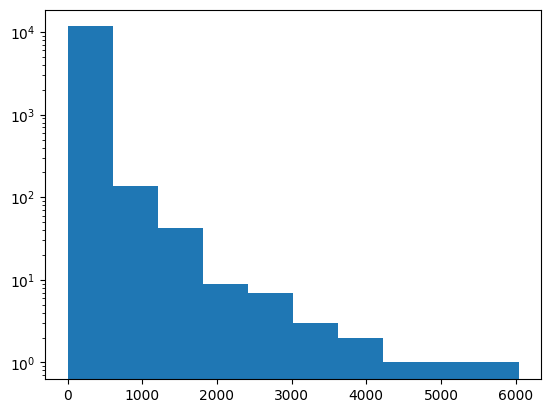

In [5]:
plt.hist(mean_reviews["count"], bins=10, log=True)

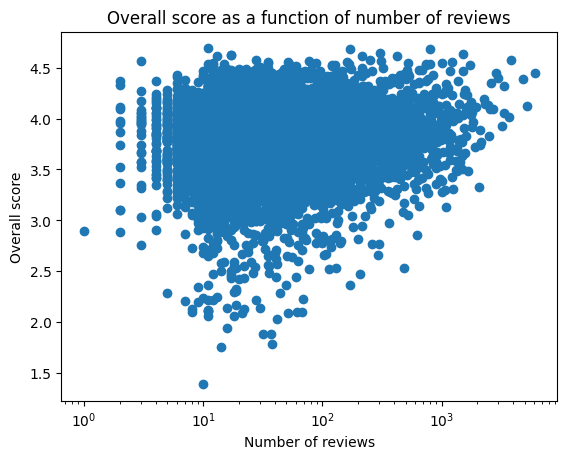

In [6]:
# plot mean review as a function of count with x- axis in log scale
plt.scatter(mean_reviews["count"], mean_reviews["mean"])
plt.xscale("log")
plt.xlabel("Number of reviews")
plt.ylabel("Overall score")
plt.title("Overall score as a function of number of reviews")
plt.show()

In [7]:
# select 5 most popular beers:
most_popular = mean_reviews.sort_values("count", ascending=False).head(5)
most_popular

,mean,count
beer_name,,
Trappistes Rochefort 10,4.447756,6039
Brooklyn Black Chocolate Stout,4.120548,5221
AleSmith Speedway Stout,4.392940,4790
Sip Of Sunshine IPA,4.576722,3844
Delirium Tremens,4.021063,3687


In [17]:
reviews_top_5 = us_users_ratings[us_users_ratings["beer_name"].isin(most_popular.index)].dropna(subset=["beer_name", "overall"])

In [18]:
# mean overall rating for each beer of the top 5 and each climate zone:
mean_top_5 = reviews_top_5.groupby(["beer_name", "climate"])["overall"].mean()
mean_top_5 = mean_top_5.reset_index()
mean_top_5 = mean_top_5.pivot(index="beer_name", columns="climate")
mean_top_5.columns = mean_top_5.columns.droplevel()
mean_top_5 = mean_top_5.reset_index()
# set beer_name as index and remove current index
mean_top_5 = mean_top_5.set_index("beer_name")
mean_top_5

climate,Bsk,Cfa,Cfb,Csa,Csb,Dfa,Dfb,Dfc,Dsb,Dsc
beer_name,,,,,,,,,,
AleSmith Speedway Stout,4.542215,4.391864,4.421745,4.433376,4.453101,4.371124,4.377559,4.400618,4.346845,4.404762
Brooklyn Black Chocolate Stout,4.153723,4.123647,4.045395,4.133151,4.130031,4.101682,4.120351,4.111422,4.171278,4.301809
Delirium Tremens,3.982546,4.027527,3.941729,4.020253,4.020898,4.048776,4.009568,3.920565,3.970787,4.034211
Sip Of Sunshine IPA,4.549890,4.587066,4.625000,4.522827,4.488657,4.554054,4.609698,4.497944,4.456620,4.328947
Trappistes Rochefort 10,4.399574,4.475866,4.585283,4.441649,4.400630,4.403099,4.444076,4.440093,4.423304,4.496930


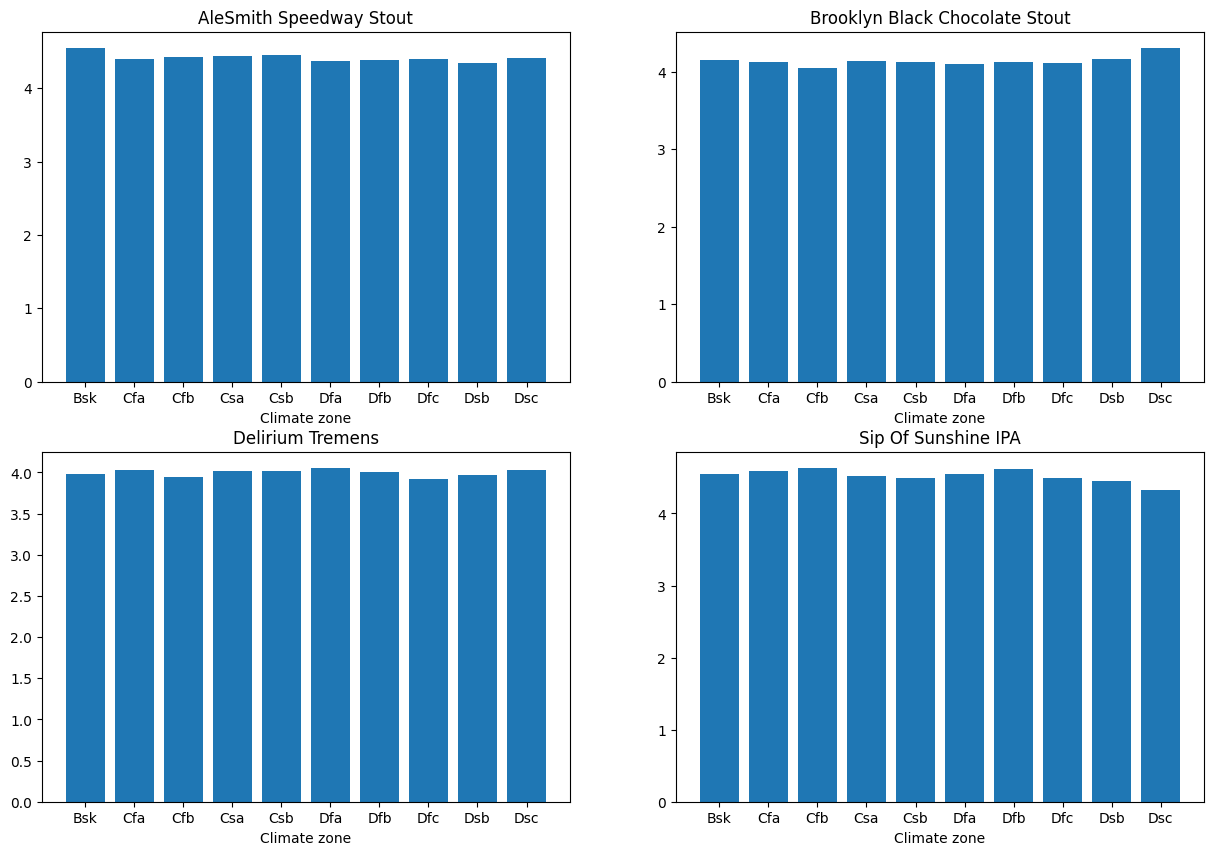

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i in range(4):
    row = i // 2
    col = i % 2

    axs[row, col].bar(mean_top_5.columns, mean_top_5.iloc[i])
    axs[row, col].set_title(mean_top_5.index[i])
    axs[row, col].set_xlabel("Climate zone")

plt.show()

In [21]:
from scipy import stats

for beer_name in reviews_top_5.beer_name.unique():
    reviews = reviews_top_5[reviews_top_5["beer_name"] == beer_name][
        ["beer_name", "climate", "overall"]
    ]
    # do anova test to compare mean overall rating for first beer of the top 5 and each climate zone:
    res = stats.f_oneway(
        *[
            reviews[reviews["climate"] == zone]["overall"].values
            for zone in reviews.climate.unique()
        ]
    )
    
    print("For beer {} the p-value is {}".format(beer_name, res.pvalue))

For beer AleSmith Speedway Stout the p-value is 0.001950239026925649
For beer Brooklyn Black Chocolate Stout the p-value is 0.7347580245724668
For beer Sip Of Sunshine IPA the p-value is 3.3679809994843754e-06
For beer Trappistes Rochefort 10 the p-value is 0.0010290771991453356
For beer Delirium Tremens the p-value is 0.5247106400409453


# Intrayear evolution of the mean ratings

We also wanted to investigate how the appreciation of beer might evolve over time. To do so, we plotted the mean rating of beers as a function of the month of the year.

First, we plot the overall mean using the full dataset.

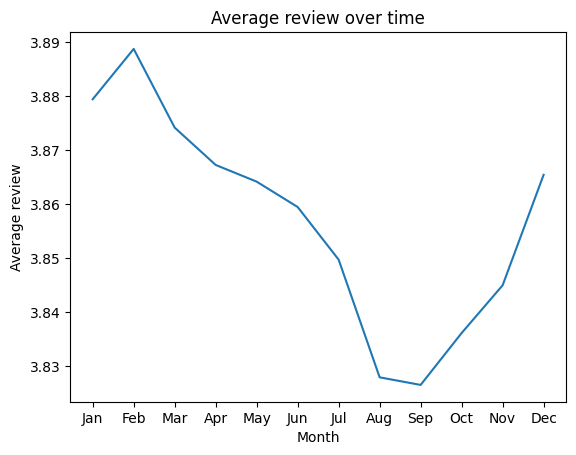

In [33]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# evolution of the average reviews over time: convert date in unix to datetime
us_users_ratings["date"] = pd.to_datetime(us_users_ratings["date"], unit="s")
us_users_ratings["year"] = us_users_ratings["date"].dt.year
us_users_ratings["month"] = us_users_ratings["date"].dt.month
# plot average review over time but keep only month that have enough reviews
us_users_ratings.groupby("month")["overall"].mean().plot()
plt.xlabel("Month")
plt.ylabel("Average review")
plt.title("Average review over time")
plt.xticks(np.arange(1, 13, 1), months)
plt.show()

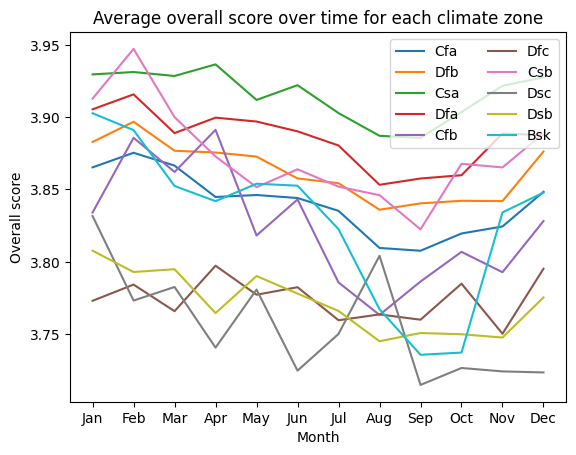

In [44]:
# # evolution of the average reviews over time: convert date in unix to datetime
# us_users_ratings["date"] = pd.to_datetime(us_users_ratings["date"], unit="s")
# us_users_ratings["year"] = us_users_ratings["date"].dt.year
# us_users_ratings["month"] = us_users_ratings["date"].dt.month
# #plot average review over time but keep only month that have enough reviews
# us_users_ratings.groupby("month")["overall"].mean().plot()
# plt.show()

# repeat the above for each climate zone
for zone in us_users_ratings["climate"].unique():
    us_users_ratings[us_users_ratings["climate"] == zone].groupby("month")[
        "overall"
    ].mean().plot(label=zone)

plt.xticks(range(1, 13), months)
plt.xlabel("Month")
plt.ylabel("Overall score")
plt.legend(loc="upper right", ncol=2)
plt.title("Average overall score over time for each climate zone")
plt.show()

It is hard to see if the variations for each climate are different, we plot the difference in between months for each climate.

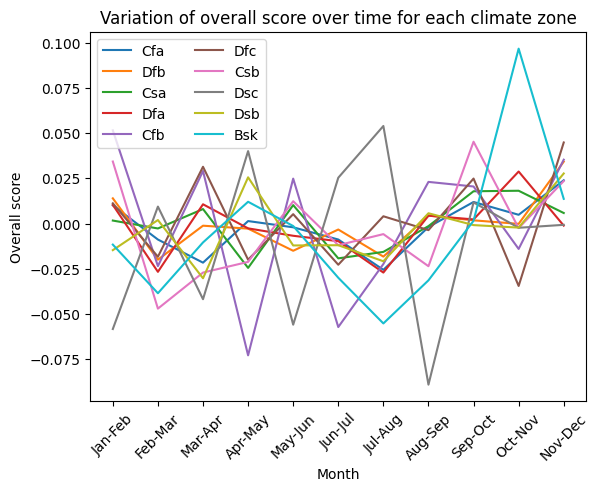

The p-value for the variation is 0.9981700383514995


In [54]:
rating_along_year = np.zeros((12, len(us_users_ratings["climate"].unique())))
for i, zone in enumerate(us_users_ratings["climate"].unique()):
    rating_along_year[:, i] = us_users_ratings[us_users_ratings["climate"] == zone].groupby("month")[
        "overall"
    ].mean()
    
variation_along_year = np.diff(rating_along_year, axis=0)
plt.plot(variation_along_year)
plt.title("Variation of overall score over time for each climate zone")
plt.xlabel("Month")
plt.ylabel("Overall score")
plt.xticks(range(11), [months[i] + "-" + months[i+1] for i in range(11)], rotation=45)
plt.legend(us_users_ratings["climate"].unique(), loc="upper left", ncol=2)
plt.show()
    
# Perform one-way ANOVA between the climate zones
res = stats.f_oneway(*[variation_along_year[:, i] for i in range(len(us_users_ratings["climate"].unique()))])
print("The p-value for the variation is {}".format(res.pvalue))

It appears that there are no statistically significant differences between the climates. We therefore will now look at various sub-categories of climate.

First, let's separate the climates by their scheme.

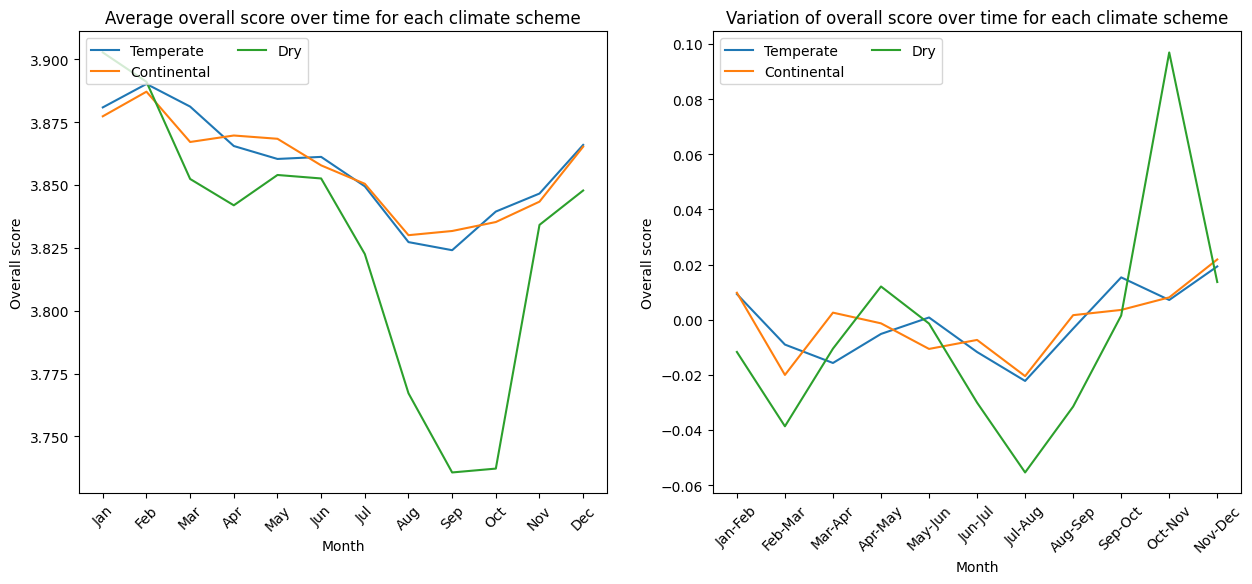

The p-value is 0.9232175462241221


In [56]:
rating_along_year_schemes = np.zeros((12, len(us_users_ratings["climate_scheme"].unique())))
for i, climate_scheme in enumerate(us_users_ratings["climate_scheme"].unique()):
    rating_along_year_schemes[:, i] = us_users_ratings[us_users_ratings["climate_scheme"] == climate_scheme].groupby("month")[
        "overall"
    ].mean()
    
variation_along_year_schemes = np.diff(rating_along_year_schemes, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(rating_along_year_schemes)
axs[0].set_title("Average overall score over time for each climate scheme")
axs[0].set_xlabel("Month")
axs[0].set_ylabel("Overall score")
axs[0].set_xticks(range(12))
axs[0].set_xticklabels(months, rotation=45)
axs[0].legend(us_users_ratings["climate_scheme"].unique(), loc="upper left", ncol=2)

axs[1].plot(variation_along_year_schemes)
axs[1].set_title("Variation of overall score over time for each climate scheme")
axs[1].set_xlabel("Month")
axs[1].set_ylabel("Overall score")
axs[1].set_xticks(range(11))
axs[1].set_xticklabels([months[i] + "-" + months[i+1] for i in range(11)], rotation=45)
axs[1].legend(us_users_ratings["climate_scheme"].unique(), loc="upper left", ncol=2)

plt.show()


# Perform one-way ANOVA between the climate zones
res = stats.f_oneway(*[variation_along_year_schemes[:, i] for i in range(len(us_users_ratings["climate_scheme"].unique()))])
print("The p-value is {}".format(res.pvalue))

Let's now do the same but looking at the precipitation.

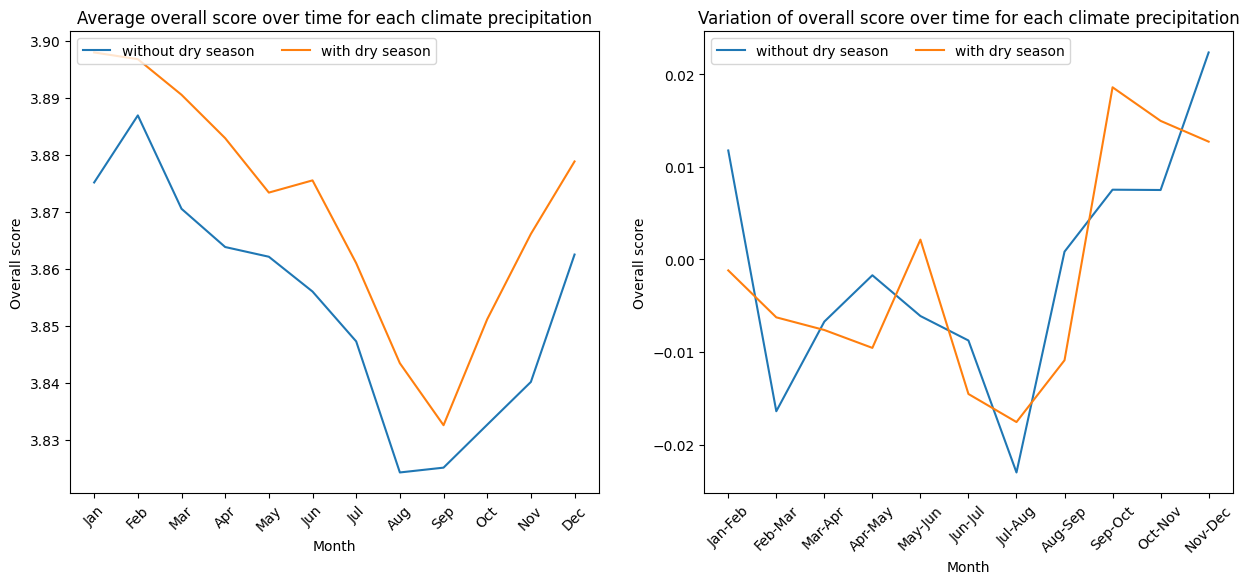

The p-value is 0.9145164854888385


In [57]:
rating_along_year_precipitation = np.zeros((12, len(us_users_ratings["climate_precipitation"].unique())))

for i, climate_precipitation in enumerate(us_users_ratings["climate_precipitation"].unique()):
    rating_along_year_precipitation[:, i] = us_users_ratings[us_users_ratings["climate_precipitation"] == climate_precipitation].groupby("month")[
        "overall"
    ].mean()
    
variation_along_year_precipitation = np.diff(rating_along_year_precipitation, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(rating_along_year_precipitation)
axs[0].set_title("Average overall score over time for each climate precipitation")
axs[0].set_xlabel("Month")
axs[0].set_ylabel("Overall score")
axs[0].set_xticks(range(12))
axs[0].set_xticklabels(months, rotation=45)
axs[0].legend(us_users_ratings["climate_precipitation"].unique(), loc="upper left", ncol=2)

axs[1].plot(variation_along_year_precipitation)
axs[1].set_title("Variation of overall score over time for each climate precipitation")
axs[1].set_xlabel("Month")
axs[1].set_ylabel("Overall score")
axs[1].set_xticks(range(11))
axs[1].set_xticklabels([months[i] + "-" + months[i+1] for i in range(11)], rotation=45)
axs[1].legend(us_users_ratings["climate_precipitation"].unique(), loc="upper left", ncol=2)

plt.show()

# Perform one-way ANOVA between the climate zones
res = stats.f_oneway(*[variation_along_year_precipitation[:, i] for i in range(len(us_users_ratings["climate_precipitation"].unique()))])
print("The p-value is {}".format(res.pvalue))

Finally, we can look at the temperature.

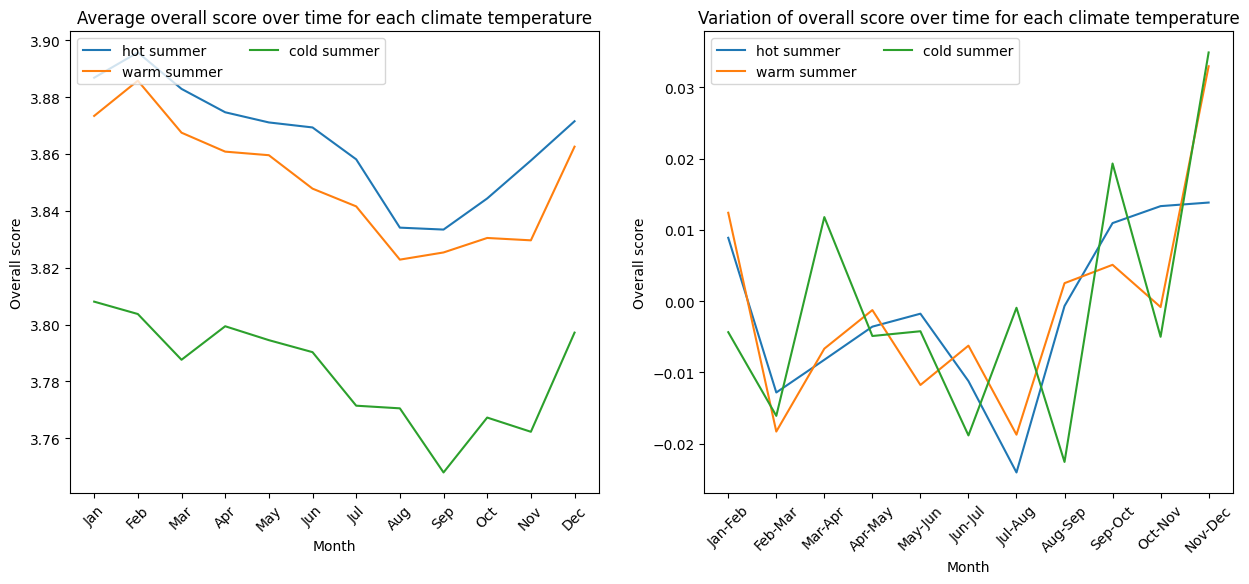

The p-value is 0.9972688198025134


In [58]:
rating_along_year_temperature = np.zeros((12, len(us_users_ratings["climate_temperature"].unique())))
for i, climate_temperature in enumerate(us_users_ratings["climate_temperature"].unique()):
    rating_along_year_temperature[:, i] = us_users_ratings[us_users_ratings["climate_temperature"] == climate_temperature].groupby("month")[
        "overall"
    ].mean()
    
variation_along_year_temperature = np.diff(rating_along_year_temperature, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(rating_along_year_temperature)
axs[0].set_title("Average overall score over time for each climate temperature")
axs[0].set_xlabel("Month")
axs[0].set_ylabel("Overall score")
axs[0].set_xticks(range(12))
axs[0].set_xticklabels(months, rotation=45)
axs[0].legend(us_users_ratings["climate_temperature"].unique(), loc="upper left", ncol=2)

axs[1].plot(variation_along_year_temperature)
axs[1].set_title("Variation of overall score over time for each climate temperature")
axs[1].set_xlabel("Month")
axs[1].set_ylabel("Overall score")
axs[1].set_xticks(range(11))
axs[1].set_xticklabels([months[i] + "-" + months[i+1] for i in range(11)], rotation=45)
axs[1].legend(us_users_ratings["climate_temperature"].unique(), loc="upper left", ncol=2)

plt.show()

# Perform one-way ANOVA between the climate zones
res = stats.f_oneway(*[variation_along_year_temperature[:, i] for i in range(len(us_users_ratings["climate_temperature"].unique()))])
print("The p-value is {}".format(res.pvalue))